In [1]:
# =============================
#   1) Import Libraries
# =============================
import os
import numpy as np
import cv2
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# =============================
#   2) Paths
# =============================
DATA_DIR = "/kaggle/input/kvasir-seg/Kvasir-SEG" 

IMG_DIR = os.path.join(DATA_DIR, "images")
MASK_DIR = os.path.join(DATA_DIR, "masks")

images = sorted(glob(os.path.join(IMG_DIR, "*.jpg")))
masks  = sorted(glob(os.path.join(MASK_DIR, "*.jpg")))

print("Total images:", len(images))

Total images: 1000


In [3]:
# =============================
#   3) Dataset Class
# =============================
class KvasirDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (256, 256))
        mask  = cv2.resize(mask, (256, 256))

        image = image / 255.0
        mask  = mask / 255.0

        image = np.transpose(image, (2, 0, 1))
        image = torch.tensor(image, dtype=torch.float32)
        mask  = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask

In [4]:
# =============================
#   4) Train/Test Split
# =============================
train_x, test_x, train_y, test_y = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

train_dataset = KvasirDataset(train_x, train_y)
test_dataset  = KvasirDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [5]:
# =============================
#   5) UNet Model
# =============================
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.d1 = DoubleConv(3, 64)
        self.d2 = DoubleConv(64, 128)
        self.d3 = DoubleConv(128, 256)
        self.d4 = DoubleConv(256, 512)

        self.bottleneck = DoubleConv(512, 1024)

        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.u1  = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.u2  = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.u3  = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.u4  = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        c1 = self.d1(x)
        p1 = self.pool(c1)

        c2 = self.d2(p1)
        p2 = self.pool(c2)

        c3 = self.d3(p2)
        p3 = self.pool(c3)

        c4 = self.d4(p3)
        p4 = self.pool(c4)

        bn = self.bottleneck(p4)

        up1 = self.up1(bn)
        merge1 = torch.cat([up1, c4], dim=1)
        uc1 = self.u1(merge1)

        up2 = self.up2(uc1)
        merge2 = torch.cat([up2, c3], dim=1)
        uc2 = self.u2(merge2)

        up3 = self.up3(uc2)
        merge3 = torch.cat([up3, c2], dim=1)
        uc3 = self.u3(merge3)

        up4 = self.up4(uc3)
        merge4 = torch.cat([up4, c1], dim=1)
        uc4 = self.u4(merge4)

        out = self.final(uc4)
        return torch.sigmoid(out)

In [6]:
# =============================
#   6) Training Setup
# =============================
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [8]:
# =============================
#   Dice Score
# =============================
def dice_score(pred, mask, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * mask).sum()
    total = pred.sum() + mask.sum()
    dice = (2 * intersection + 1e-7) / (total + 1e-7)
    return dice.item()

# =============================
#   IoU (Intersection over Union)
# =============================
def iou_score(pred, mask, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * mask).sum()
    union = pred.sum() + mask.sum() - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou.item()

# =============================
#   Pixel Accuracy
# =============================
def pixel_accuracy(pred, mask, threshold=0.5):
    pred = (pred > threshold).float()
    correct = (pred == mask).float().sum()
    total = mask.numel()
    return (correct / total).item()


In [10]:
# =============================
#   7) Training Loop
# =============================
# =============================
# TRAINING LOOP WITH METRICS
# =============================
EPOCHS = 15

train_losses = []
val_losses   = []
train_dice   = []
val_dice     = []
train_iou    = []
val_iou      = []
train_acc    = []
val_acc      = []

best_dice = 0.0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_dice = 0
    total_iou  = 0
    total_acc  = 0

    for img, mask in train_loader:
        img, mask = img.to(device), mask.to(device)

        pred = model(img)
        loss = criterion(pred, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_score(pred, mask)
        total_iou  += iou_score(pred, mask)
        total_acc  += pixel_accuracy(pred, mask)

    # Averages for training
    train_losses.append(total_loss / len(train_loader))
    train_dice.append(total_dice / len(train_loader))
    train_iou.append(total_iou / len(train_loader))
    train_acc.append(total_acc / len(train_loader))

    # ===== VALIDATION =====
    model.eval()
    val_loss = 0
    val_dice_score_value = 0
    val_iou_score_value  = 0
    val_acc_score_value  = 0

    with torch.no_grad():
        for img, mask in test_loader:
            img, mask = img.to(device), mask.to(device)

            pred = model(img)
            loss = criterion(pred, mask)

            val_loss += loss.item()
            val_dice_score_value += dice_score(pred, mask)
            val_iou_score_value  += iou_score(pred, mask)
            val_acc_score_value  += pixel_accuracy(pred, mask)

    val_losses.append(val_loss / len(test_loader))
    val_dice.append(val_dice_score_value / len(test_loader))
    val_iou.append(val_iou_score_value / len(test_loader))
    val_acc.append(val_acc_score_value / len(test_loader))

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f" Train Loss: {train_losses[-1]:.4f}  |  Val Loss: {val_losses[-1]:.4f}")
    print(f" Train Dice: {train_dice[-1]:.4f}  |  Val Dice: {val_dice[-1]:.4f}")
    print(f" Train IoU : {train_iou[-1]:.4f}   |  Val IoU : {val_iou[-1]:.4f}")
    print(f" Train Acc : {train_acc[-1]:.4f}   |  Val Acc : {val_acc[-1]:.4f}")
    print("-"*60)


Epoch 1/15
 Train Loss: 0.3609  |  Val Loss: 0.3852
 Train Dice: 0.0000  |  Val Dice: 0.0000
 Train IoU : 0.0000   |  Val IoU : 0.0000
 Train Acc : 0.8417   |  Val Acc : 0.8336
------------------------------------------------------------
Epoch 2/15
 Train Loss: 0.3624  |  Val Loss: 0.3788
 Train Dice: 0.0000  |  Val Dice: 0.0000
 Train IoU : 0.0000   |  Val IoU : 0.0000
 Train Acc : 0.8417   |  Val Acc : 0.8336
------------------------------------------------------------
Epoch 3/15
 Train Loss: 0.3536  |  Val Loss: 0.3790
 Train Dice: 0.0000  |  Val Dice: 0.0000
 Train IoU : 0.0000   |  Val IoU : 0.0000
 Train Acc : 0.8417   |  Val Acc : 0.8336
------------------------------------------------------------
Epoch 4/15
 Train Loss: 0.3502  |  Val Loss: 0.3794
 Train Dice: 0.0000  |  Val Dice: 0.0000
 Train IoU : 0.0000   |  Val IoU : 0.0000
 Train Acc : 0.8417   |  Val Acc : 0.8336
------------------------------------------------------------
Epoch 5/15
 Train Loss: 0.3446  |  Val Loss: 0.3

In [14]:
# Save best model
if val_dice[-1] > best_dice:
    best_dice = val_dice[-1]
    torch.save(model.state_dict(), "best_unet_kvasir.pth")
    print("Saved new best model!")


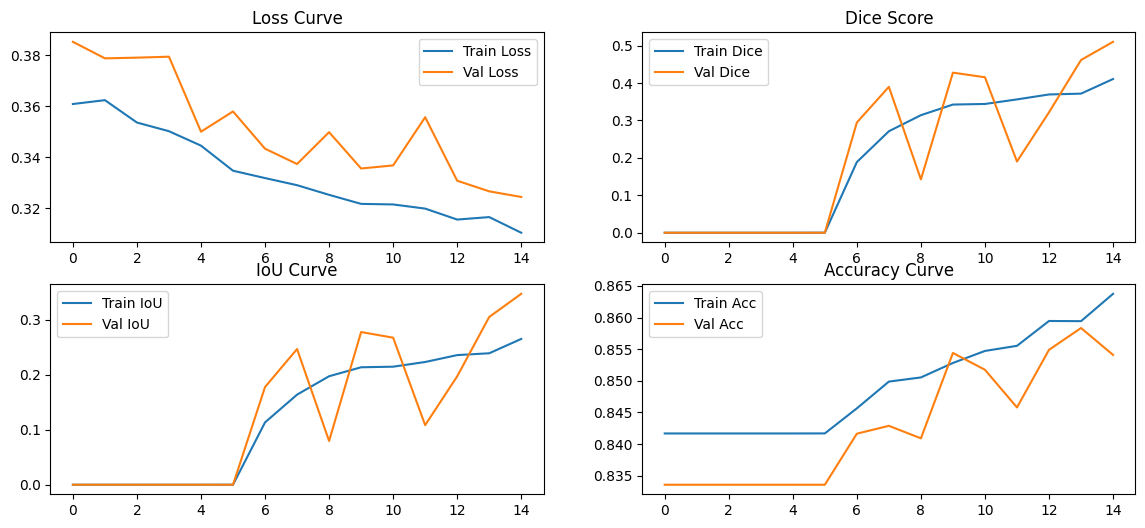

In [15]:
# =============================
# PLOT METRICS
# =============================
plt.figure(figsize=(14, 6))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(2, 2, 2)
plt.plot(train_dice, label="Train Dice")
plt.plot(val_dice, label="Val Dice")
plt.legend()
plt.title("Dice Score")

plt.subplot(2, 2, 3)
plt.plot(train_iou, label="Train IoU")
plt.plot(val_iou, label="Val IoU")
plt.legend()
plt.title("IoU Curve")

plt.subplot(2, 2, 4)
plt.plot(train_acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


In [17]:
# =============================
#   Show Image, GT Mask, Predicted Mask
# =============================
def show_result(model, dataset, index=0):
    model.eval()
    img, true_mask = dataset[index]

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
    
    pred = pred.cpu().numpy()[0][0]
    img_np = img.numpy().transpose(1, 2, 0)
    true_np = true_mask.numpy()[0]

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(img_np)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(true_np, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred, cmap="gray")
    plt.axis("off")

    plt.show()


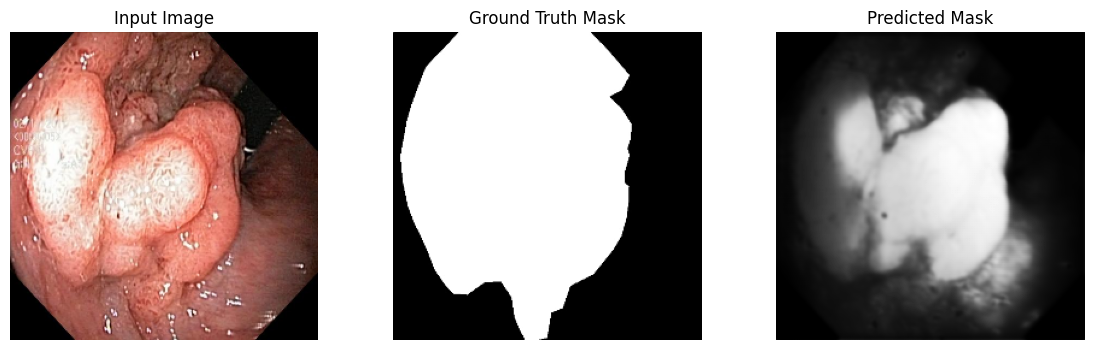

In [18]:
show_result(model, test_dataset, index=5)
